In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.integrate import quad
from scipy.stats import gamma
import scipy.special as sc

$\def\op#1{\operatorname{#1}}
\def\E{\op{E}}
\def\var#1{\op{var{#1}}}$

This script is going to implement the Gamma Generated Tree algorithm 3 in I-Hsiang's paper

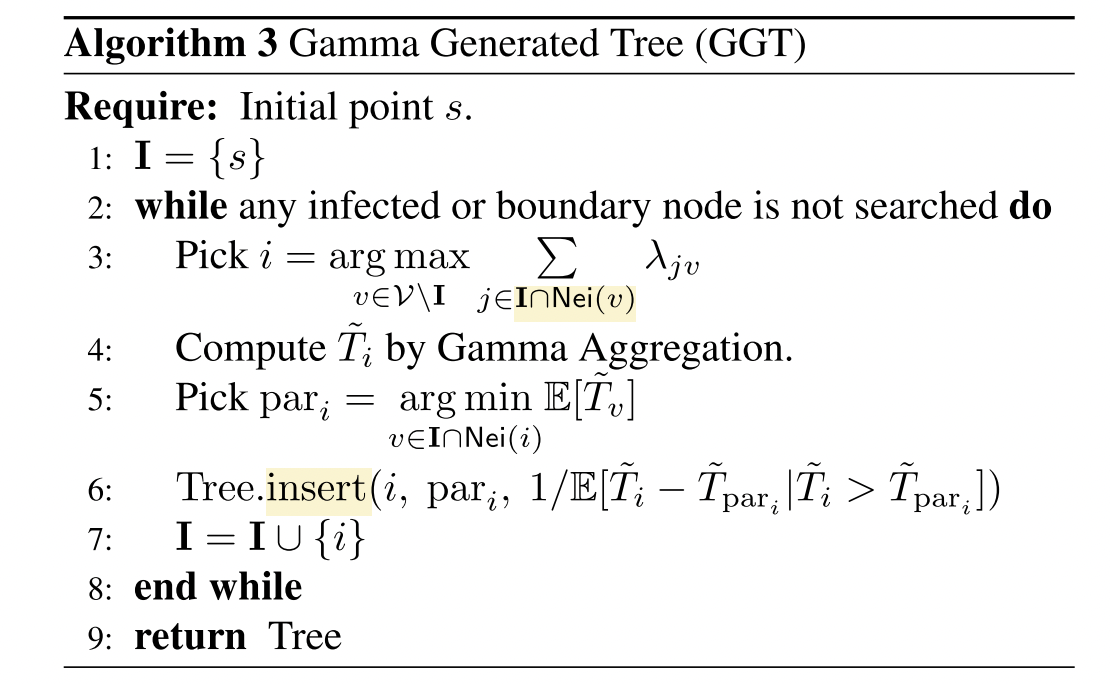

# An example of GGT generating from a weighted graph



## Firstly we generate a weighted graph by setting the weight manually.


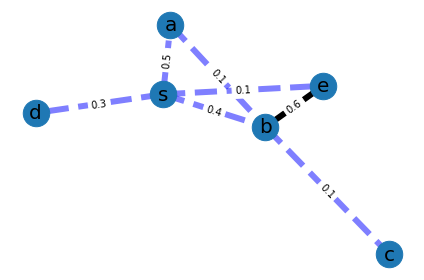

In [2]:
G = nx.Graph()
G.add_nodes_from(["s", "a", "b", "c", "d", "e"])
G.add_edge("s", "a", weight=0.5)
G.add_edge("s", "b", weight=0.4)
G.add_edge("s", "d", weight=0.3)
G.add_edge("s", "e", weight=0.1)
G.add_edge("a", "b", weight=0.1)
G.add_edge("b", "c", weight=0.1)
G.add_edge("b", "e", weight=0.6)

def draw_graph(G):
    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

    pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=700)

    # edges
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)
    nx.draw_networkx_edges(
        G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
    )

    # node labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
    # edge weight labels
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels)

    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

draw_graph(G)



Assume that we randomly select node $s$ as the source node of the spreading where the time variable $t$ is $0$. It is easy to find $\E [\tilde{T}_s] = 0$ and $\var{[\tilde{T}_s]} = 0$. Now we go into the ```while``` loop in **Algorithm 3**.

1. Since all of the nodes $a, b, d, e$ linked with source $s$ have only one candidate parent according to $j \in \{s\} \cap \op{Nei}(v) $, we can find $i$ by comparing the $\lambda_{si}, i = a, b, d, e$, which can also regarded as comparing the weights. Thus, $i = a$.
2. $\tilde{T}_a \sim \Gamma (k_1, r_1)$ with $\E [\tilde{T}_a] = \E [\tilde{T}_s] + \frac{1}{\lambda_{sa}} = \frac{1}{\lambda_{sa}}$ and $\var{[\tilde{T}_a]} = \frac{1}{\lambda_{sa}^2}$.
3. We get the parent by the complementary CDF (CCDF), where $\op{ccdf}(\min(\tilde{T}_{p_j})) = \prod_{p_j} \op{ccdf}(\tilde{T}_{p_j})$. For the fisrt spreading step, $\op{ccdf}(\min(\tilde{T}_{p_j})) = \op{ccdf}(\tilde{T}_s)$, which can be further calculated by Eq.3.
4. Insert these nodes to the tree.

## One trivial example (first spreading)

In [3]:
def find_next_child(G, source_node):
    child_node = None
    max_weight = 0
    for node in source_node:
        for neighbor in G.neighbors(node):
            #print(f"neighbor is {neighbor}")
            if neighbor not in source_node:
                weight = G[node][neighbor]['weight']
                if weight > max_weight:
                    max_weight = weight
                    child_node = neighbor
                    #print(f"child node is {child_node}")
    return child_node

def find_parents(i, G, source=['s']):
    parent_node = []
    # First get all the neighbors of node i
    candidate = G.neighbors(i)
    for n in candidate:
        # Find the nodes in the source set
        if n in source:
            parent_node.append(n)
    return parent_node

To find the next infected child node based on edge weights.

In [4]:
print(f"The next child node of source {['a']} is {find_next_child(G, ['a'])}.")
print(f"The next child node of source {['a','c']} is {find_next_child(G, ['a','c'])}.")

The next child node of source ['a'] is s.
The next child node of source ['a', 'c'] is s.


To find the candidate parent set of a node $i$ based on the source set $I$.

In [5]:
print(find_parents('a', G, source=['s']))
print(find_parents('b', G, source=['s', 'a']))
print(find_parents('s', G))

['s']
['s', 'a']
[]


To find the parent of a node $i$ with a given source set $I$, we need to find the minimal expectation and compute the relavant variance by the integration of the product of CCDF.

$$\begin{align} \E\left[\min\tilde{T}_{p_j}\right] = \int_0^{\infty }\op{ccdf}(\min\tilde{T}_{p_j}) = \int_0^{\infty} \prod_{p_j} \op{ccdf}(\tilde{T}_{p_j})\\
\var{\left[\min\tilde{T}_{p_j}\right]} = \E\left[(\min\tilde{T}_{p_j})^2\right] - \E\left[\min\tilde{T}_{p_j}\right]^2\end{align}$$

In [6]:
# We use theta instead of r in the paper.
def compute_ccdf(x, k, theta):
    return 1 - gamma.cdf(x, k, scale=theta)

I = ['s']
def product_ccdf(t, j, k, theta):
    v = 1
    for par in find_parents(j, G, source=I):
        v *= compute_ccdf(t, k[par], theta[par])
    return v

def integrand_moment(t, j, k, theta, p):
    return p * t**(p - 1) * product_ccdf(t, j, k, theta)

def compute_moment(j, k, theta, p):
    return quad(integrand_moment, 0, np.inf, args=(j, k, theta, p))[0]


In [7]:
lambda_sa = G.get_edge_data('s', 'a')['weight']
#print(lambda_sa)

# Assume k and r are both 1 for node s with expectation and variance are 1.
theta_s = 3
k_s = 4
E_s = k_s/theta_s
V_s = k_s/theta_s**2

# Calculate k and r for node a
def compute_theta(E, V, lambda_p):
    return (E + 1/lambda_p) / (V + 1/lambda_p**2)

def compute_k(E, V, lambda_p):
    return (E + 1/lambda_p)**2 / (V + 1/lambda_p**2)

theta_a = compute_theta(E_s, V_s, lambda_sa)
k_a = compute_k(E_s, V_s, lambda_sa)

print(theta_a, k_a)


0.7499999999999999 2.4999999999999996


In [8]:
j = 'a'
k = {'s': k_s}
theta = {'s': theta_s}

moment_1 = compute_moment(j, k, theta, 1)
moment_2 = compute_moment(j, k, theta, 2)

print(
    f'The first moment is {moment_1}.\nThe second moment is {moment_2}.\nThe expectation is {moment_1}.\nThe variance is {moment_2 - moment_1**2}.'
    )

The first moment is 12.0.
The second moment is 179.99999999999966.
The expectation is 12.0.
The variance is 35.99999999999966.


In [9]:
##compute expectation in line 6, equation 3
def compute_expectation(k1, r1, k2, r2):
  beta_top = sc.betainc(k2+1, k1, r2/(r1+r2))
  beta_down = sc.betainc(k2, k1, r2/(r1+r2))
  expectation = (k1+k2) / r1 - k2*(r1+r2) / (r1*r2) * (beta_top / beta_down)
  return 1/expectation

lambda_sa_1 = compute_expectation(k_a, theta_a, k_s, theta_s)

Then we grow the tree by adding the source $s$ and the first infected node $a$.

['s', 'a']
0.39570229000066


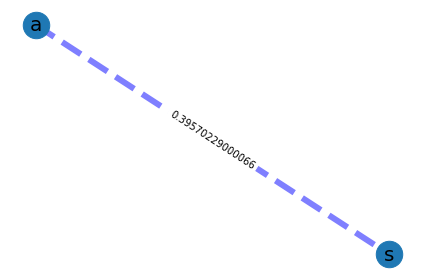

In [10]:
T = nx.Graph()
T.add_edge('a', 's', weight=lambda_sa_1)
I.append('a')
print(I)

print(lambda_sa_1)
draw_graph(T)

## The next spreading example

In [11]:
next_node = find_next_child(G, I)
lambda_1 = G.get_edge_data('s', next_node)['weight']
lambda_2 = G.get_edge_data('a', next_node)['weight']

# For node s, we now compute the k and r
k_bs = compute_k(E_s, V_s, lambda_1)
theta_bs = compute_theta(E_s, V_s, lambda_1)
print(k_bs, theta_bs)

k_1 = {'s': k_s, 'a': k_a, 'b': k_bs}
theta_1 = {'s': theta_s, 'a': theta_a, 'b': theta_bs}

2.195020746887967 0.5726141078838174


In [12]:
E_a = moment_1
V_a = moment_2 - moment_1**2

k_ba = compute_k(E_a, V_a, lambda_2)
theta_ba = compute_theta(E_a, V_a, lambda_2)
print(k_ba, theta_ba)

moment_1_b = compute_moment(next_node, k_1, theta_1, 1)
moment_2_b = compute_moment(next_node, k_1, theta_1, 2)

print(moment_1_b, moment_2_b, moment_2_b - moment_1_b**2)

3.558823529411774 0.16176470588235334
1.8636355298409286 4.832802964266116 1.359665576180637


In [14]:
E_b = moment_1_b
V_b = moment_2_b - moment_1_b**2

lambda_sb_1 = compute_expectation(k_bs, theta_bs, k_s, theta_s)
print(lambda_sb_1)

0.32727065915523346


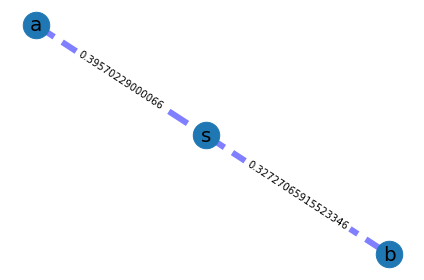

In [15]:
I.append(next_node)
T.add_edge('s', next_node, weight=lambda_sb_1)

draw_graph(T)

In [16]:
j = find_next_child(G, I)
print(j)


e


## In the following part, I use node "a" "d" as the source nodes to reproduce the steps indicated in the algorithm. If this is correct, we can then package them into a while loop to search a complete tree.

In [13]:
# a trivial example that the initial point is "a"
# set intial point
source_nodes = ['a']
sequence = []
# choose the next infected node
child_node = find_next_child(G, source_nodes)
# update parent from a
# shape = mean **2 / var
# scale = mean / var
lambda_a = G['a'][child_node]['weight']
mean_a = 0 + 1/lambda_a
var_a = 0 + 1/lambda_a ** 2
k = mean_a ** 2 /var_a
theta = mean_a / var_a
print(f"shape is {k}")
print(f"scale is {theta}")
ccdf_a = compute_ccdf(k, theta)
mean_a = compute_moment(ccdf_a, 1)
var_a = compute_moment(ccdf_a, 2)


# update the parent of node d to be node a
parent = ['a'][np.argmin([mean_a])]
print(f"parent of {'d'} is {parent}")
# add the child node to the source node
# add the parent node to the tree
sequence.append(parent)
sequence.append(child_node)
source_nodes.append(child_node)

print(f"spreading sequence is {sequence}")
print(f"source node is updated as {source_nodes}")

shape is 1.0
scale is 0.5


TypeError: compute_ccdf() missing 1 required positional argument: 'theta'

In [ ]:
#now the source node is a, d and the next infected node should be c.
# then we find the parent of c
source_nodes = ['a', 'd']

child_node = find_next_child(G, source_nodes)
print(f"next infected node is {child_node}")

#consider node a as the potential parent
lambda_ac = G['a'][child_node]['weight']
mean_ac = 0 + 1/lambda_ac
var_ac = 0 + 1/lambda_ac ** 2
k = mean_ac ** 2 /var_ac
theta = mean_ac / var_ac
print(f"shape is {k}")
print(f"scale is {theta}")
ccdf_ac = compute_ccdf(k, theta)
mean_ac = compute_moment(ccdf_ac, 1)
var_ac = compute_moment(ccdf_ac, 2)

#consider node d as the potential parent
lambda_dc = G['d'][child_node]['weight']
mean_dc = mean_a + 1/lambda_dc
var_dc = var_a + 1/lambda_dc ** 2
k = mean_dc ** 2 /var_dc
theta = mean_dc / var_dc
print(f"shape is {k}")
print(f"scale is {theta}")
ccdf_dc = compute_ccdf(k, theta)
mean_dc = compute_moment(ccdf_dc, 1)
var_dc = compute_moment(ccdf_dc, 2)

#choose parent node of c from node a and node d
#by comparing the gamma r.v. for node a and node d.
if mean_dc > mean_ac:
  parent = 'a'

else:
  parent = 'd'

# update the parent of node c
#parent = ['a', 'd'][np.argmin([mean_ac, mean_dc])]
print(f"parent of {'c'} is {parent}")
# add the child node to the source node
# add the parent node to the tree

sequence.append(child_node)
source_nodes.append(child_node)

print(f"spreading sequence is {sequence}")
print(f"updated source node is {source_nodes}")

In [ ]:
source_nodes = ['a']
sequence = []

while len(source_nodes) < len(G.nodes):

    child_node = find_next_child(G, source_nodes)
    # candidate parent node gamma R.V.
    for parent in source_nodes:
        lambda_pc = G[parent][child_node]['weight']
        mean_pc = 0 + 1/lambda_pc
        var_pc = 0 + 1/lambda_pc ** 2
        k = mean_pc ** 2 /var_pc
        theta = mean_pc / var_pc
        ccdf_pc = compute_ccdf(k, theta)
        mean_pc = compute_moment(ccdf_pc, 1)
        var_pc = compute_moment(ccdf_pc, 2)

    # choose parent with smallest mean
    parent = source_nodes[np.argmin([mean_pc for parent in source_nodes]) ]

    # add child_node and sequence
    source_nodes.append(child_node)
    sequence.append(parent)

print(f"Spreading sequence is {sequence}")
print(f"Source nodes are {source_nodes}")